In [2]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import xarray as xr 
import pandas as pd 
import glob

datadir = '/Users/cowherd/Documents/ASO/'
fns = glob.glob(f'{datadir}*/*American*/*.tif')
dates = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02']
dates23 = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02'] # , '2024Feb11-12']
dates_24 = ['2024Feb11-12', '2024Apr10', '2024Apr30'] # , '2024Feb11-12']
vars50 = ['NIRalbedo_50m','BBalbedo_50m', 'snowdepth_50m', 'swe_50m']
vars3 = ['snowdepth_3m', 'swe_3m']
projdir = '/Users/cowherd/Documents/caldor-snow/'
caldor = gpd.read_file(f'{projdir}/data/caldor.shp')
caldor = caldor.to_crs('epsg:4326')
srtm = xr.open_dataarray('../data/srtm30_sfa.nc')
cldrstr = 'ca3858612053820210815'
cldrdate= '20210805_20220723'
mtbs_rdnbr = xr.open_dataset(f'{projdir}/data/{cldrstr}/{cldrstr}_{cldrdate}_rdnbr.tif')
fn = glob.glob(f'{datadir}*American*/*American*{dates[1]}*{vars50[-1]}.tif')[0]
ds_50m = xr.open_rasterio(fn).rio.reproject('epsg:4326')
srtm = srtm.rio.write_crs('epsg:4326').rename({'lat':'y','lon':'x'})
srtm_50 = srtm.rio.reproject_match(ds_50m)

plt.style.use('/Users/cowherd/Documents/mplstyles/marianne.mplstyle')

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_75283/2151598749.py:23: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_50m = xr.open_rasterio(fn).rio.reproject('epsg:4326')
Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


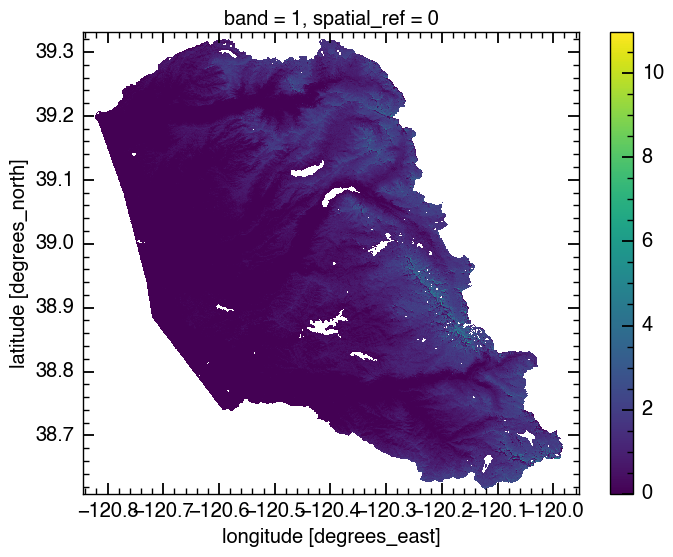

In [3]:
ds_50m.sel(band = 1). plot()

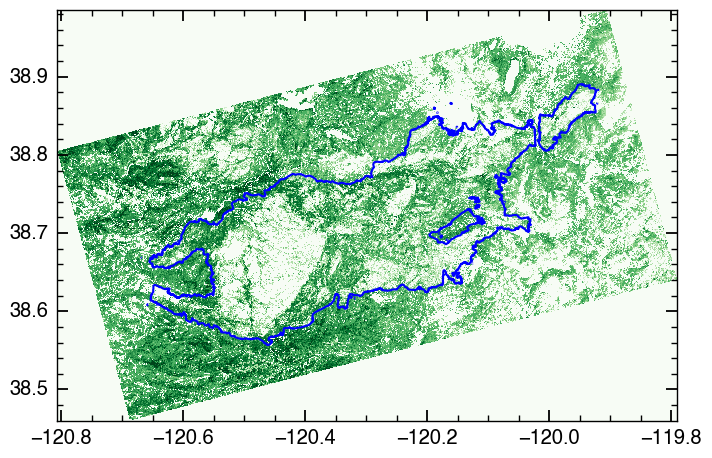

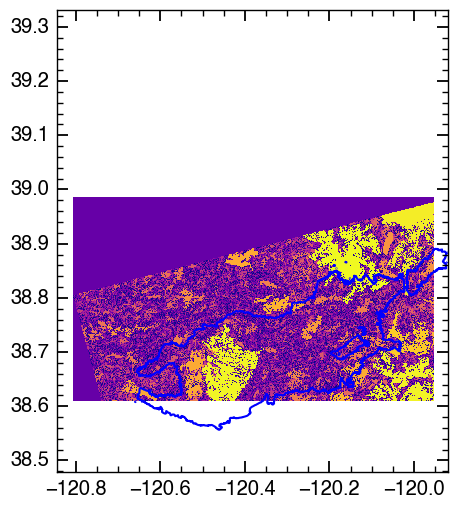

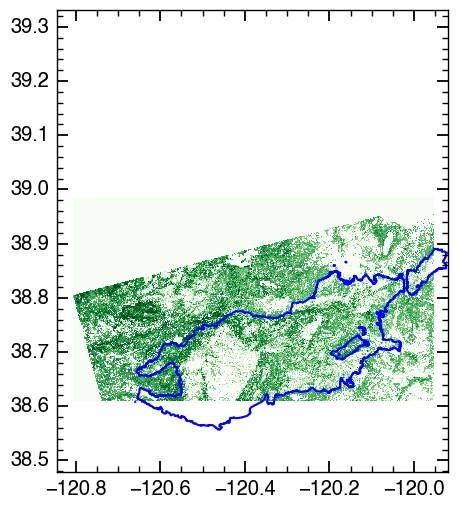

In [4]:
ds = xr.open_dataset('../data/lfcc_area.nc')
fig, ax = plt.subplots()
ax.pcolormesh(ds.x, ds.y, ds.band_data, cmap = 'Greens')
caldor.boundary.plot(ax=ax)

plt.show()
ds = ds.rio.write_crs('epsg:4326')
band_data_rp = ds.band_data.rio.reproject_match(ds_50m)
log_area_rp =  ds.log_area.rio.reproject_match(ds_50m)
fig, ax = plt.subplots()
ax.pcolormesh(log_area_rp.x, log_area_rp.y, log_area_rp, cmap = 'plasma')
caldor.boundary.plot(ax=ax)

plt.show()

fig, ax = plt.subplots()
ax.pcolormesh(band_data_rp.x, band_data_rp.y, band_data_rp, cmap = 'Greens')
caldor.boundary.plot(ax=ax)
plt.show()


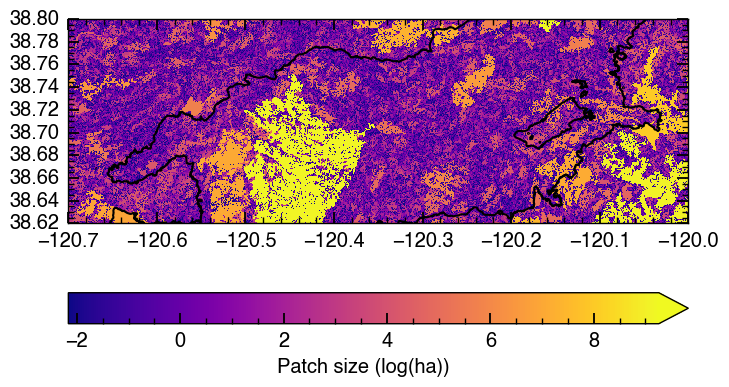

In [5]:
fig, ax = plt.subplots()
cbar = ax.pcolormesh(log_area_rp.x, log_area_rp.y, log_area_rp, cmap = 'plasma')
caldor.boundary.plot(ax=ax, color = 'k')
ax.set_ylim((38.62, 38.8))
ax.set_xlim((-120.7, -120.0))
plt.colorbar(cbar, ax=ax, label = 'Patch size (log(ha))', orientation = 'horizontal', extend = 'max')
plt.show()

In [6]:
## new raster: patch size! ## 
pyrofolder = '/Users/cowherd/Documents/pyrodiversity'   
band_data_rp = ds.band_data.rio.reproject_match(ds_50m)
log_area_rp =  ds.log_area.rio.reproject_match(ds_50m)

covercat = ["0-1", "1-40","40-60","60-100"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red", "purple"]
bounds = [0, 1, 40, 60, 100]

# Create an empty dictionary to store masks for each category
covermasks = {}

# Create masks for each category
for i in range(len(bounds) - 1):
    lower_bound = bounds[i]
    upper_bound = bounds[i + 1]
    category_label = covercat[i]

    # Create a mask for the current category
    mask = (band_data_rp >= lower_bound) & (band_data_rp < upper_bound)

    # Add the mask to the dictionary with the category label as the key
    covermasks[category_label] = mask

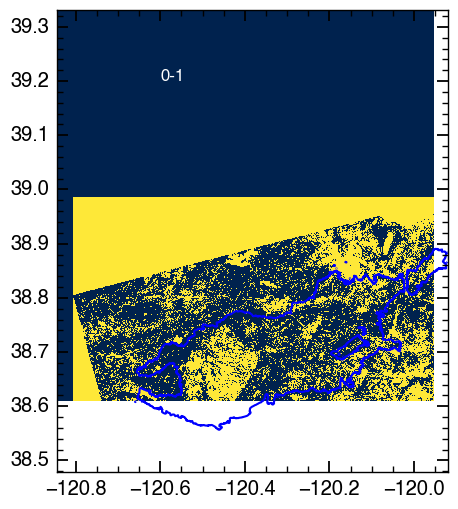

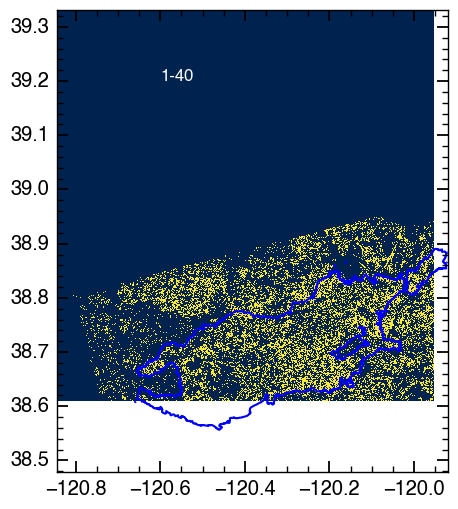

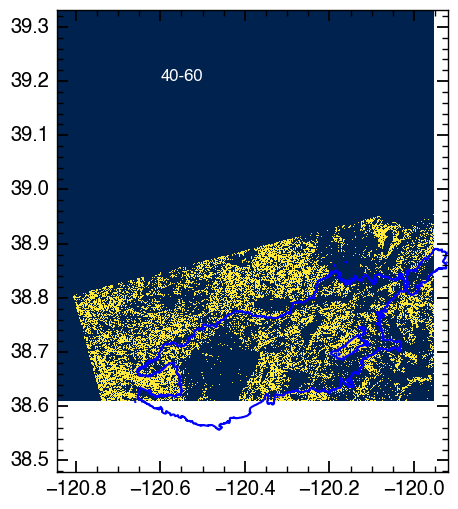

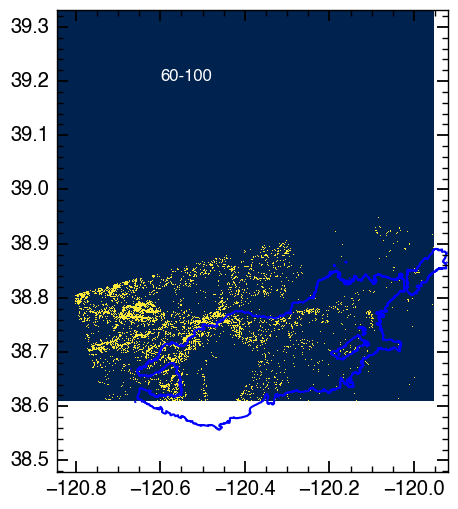

In [7]:
for cat in covermasks.keys():
    mask = covermasks[cat]
    fig, ax = plt.subplots()
    ax.pcolormesh(mask.x, mask.y, mask)
    caldor.boundary.plot(ax=ax)
    ax.text(-120.6, 39.2, cat, color = 'white')
    plt.show()

In [8]:

band_size = 150

def get_elev(ds_50, srtm_50, STATIC = False):
    # Extract elevation values from 'srtm_50' dataset
    elevation_values = srtm_50.values
    elevation_values_ft = elevation_values * 3.28084
    # Extract values from 'ds_50m' dataset
    ds_values = ds_50[0].values

    # Calculate the elevation bands
    elevation_bands = np.arange(1500, np.nanmax(elevation_values_ft), band_size)
    if STATIC:
        elevation_bands = np.arange(1500, 9000, band_size)

    # Initialize lists to store the means and percentiles
    band_means = []
    percentiles_25 = []
    percentiles_75 = []
    stds = []

    # Loop through elevation bands and calculate statistics for each band
    for band in elevation_bands:
        mask = (elevation_values_ft >= band) & (elevation_values_ft < band + band_size)
        values_in_band = ds_values[mask]
        if len(values_in_band) > 0:
            band_means.append(np.nanmedian(values_in_band))
            percentiles_25.append(np.nanpercentile(values_in_band, 25))
            percentiles_75.append(np.nanpercentile(values_in_band, 75))
            stds.append(np.nanstd(values_in_band))
        else:
            band_means.append(0)
            percentiles_25.append(0)
            percentiles_75.append(0)
            stds.append(0)

    return elevation_bands, band_means, percentiles_25, percentiles_75, stds


/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_75283/31924852.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = fu

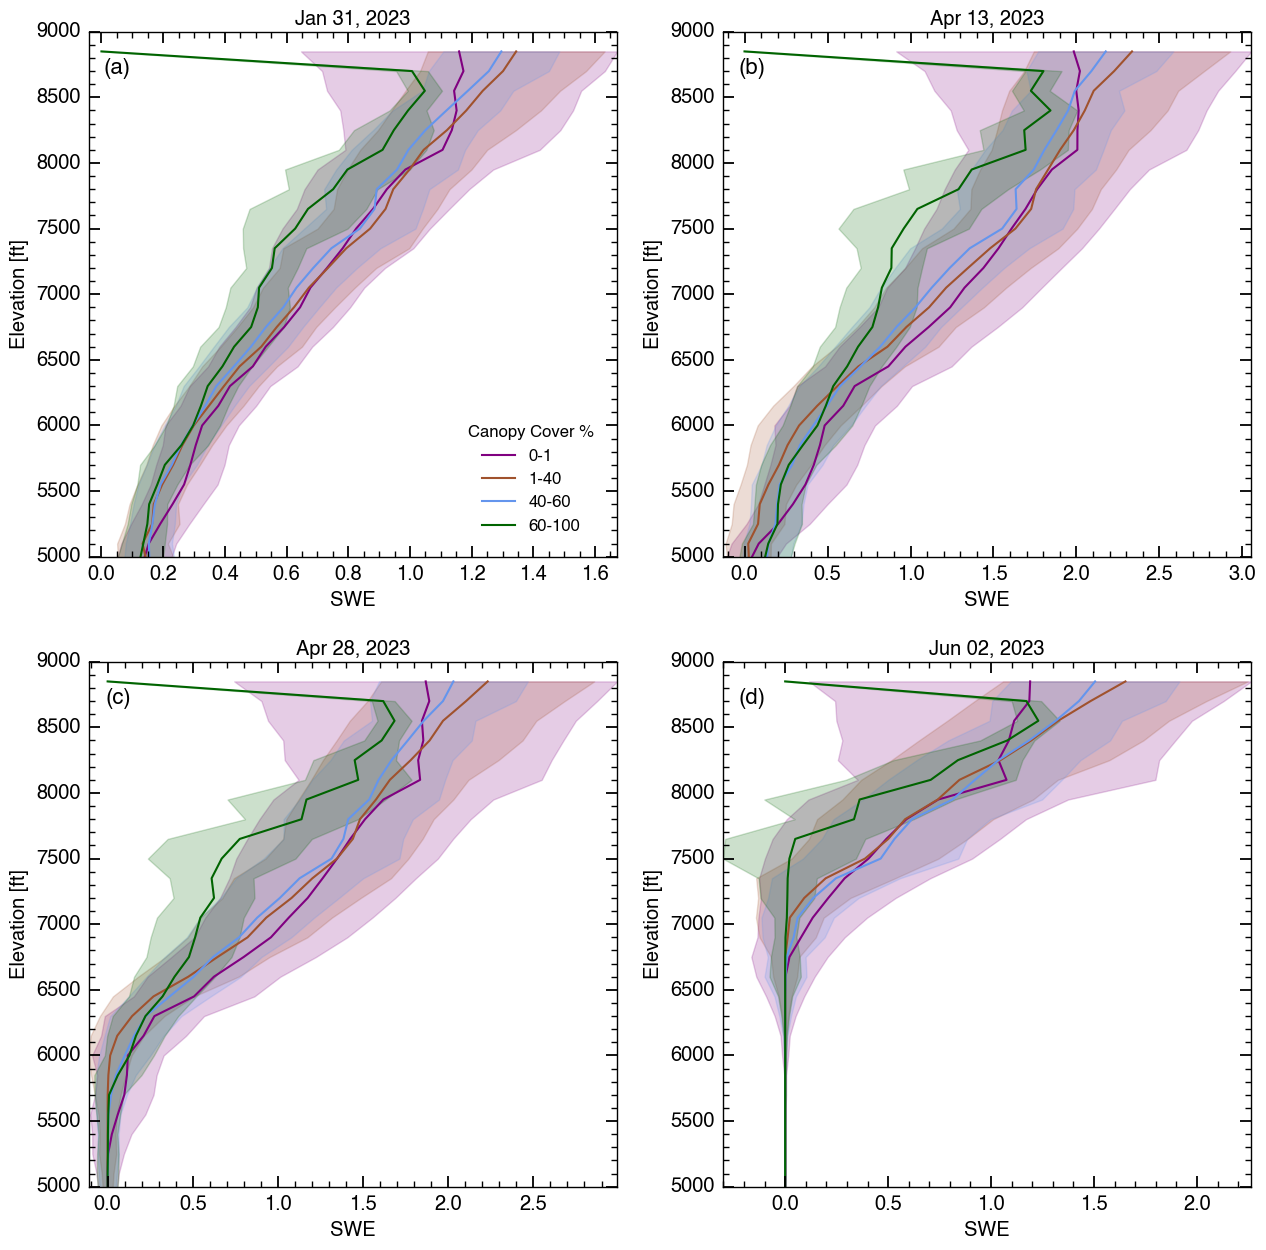

In [9]:
colors = ['purple',
          'sienna',
          'cornflowerblue',
          'darkgreen']
fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    swe = swe.rio.reproject_match(ds_50m)
    inside = swe# .rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(covercat):
        cover_mask = covermasks[category]# .rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(cover_mask)
        srtm_50_in = srtm_50.where(cover_mask)# .rio.clip(caldor.geometry, invert=False).where(cover_mask)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands, mainline  - np.array(stds), 
                        mainline +np.array(stds), elevation_bands, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')
    ax.set_xlabel('SWE')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


axs[0].legend(frameon = False, title = 'Canopy Cover %', loc = 'lower right')

plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_14012/3504223900.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  sd = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = f

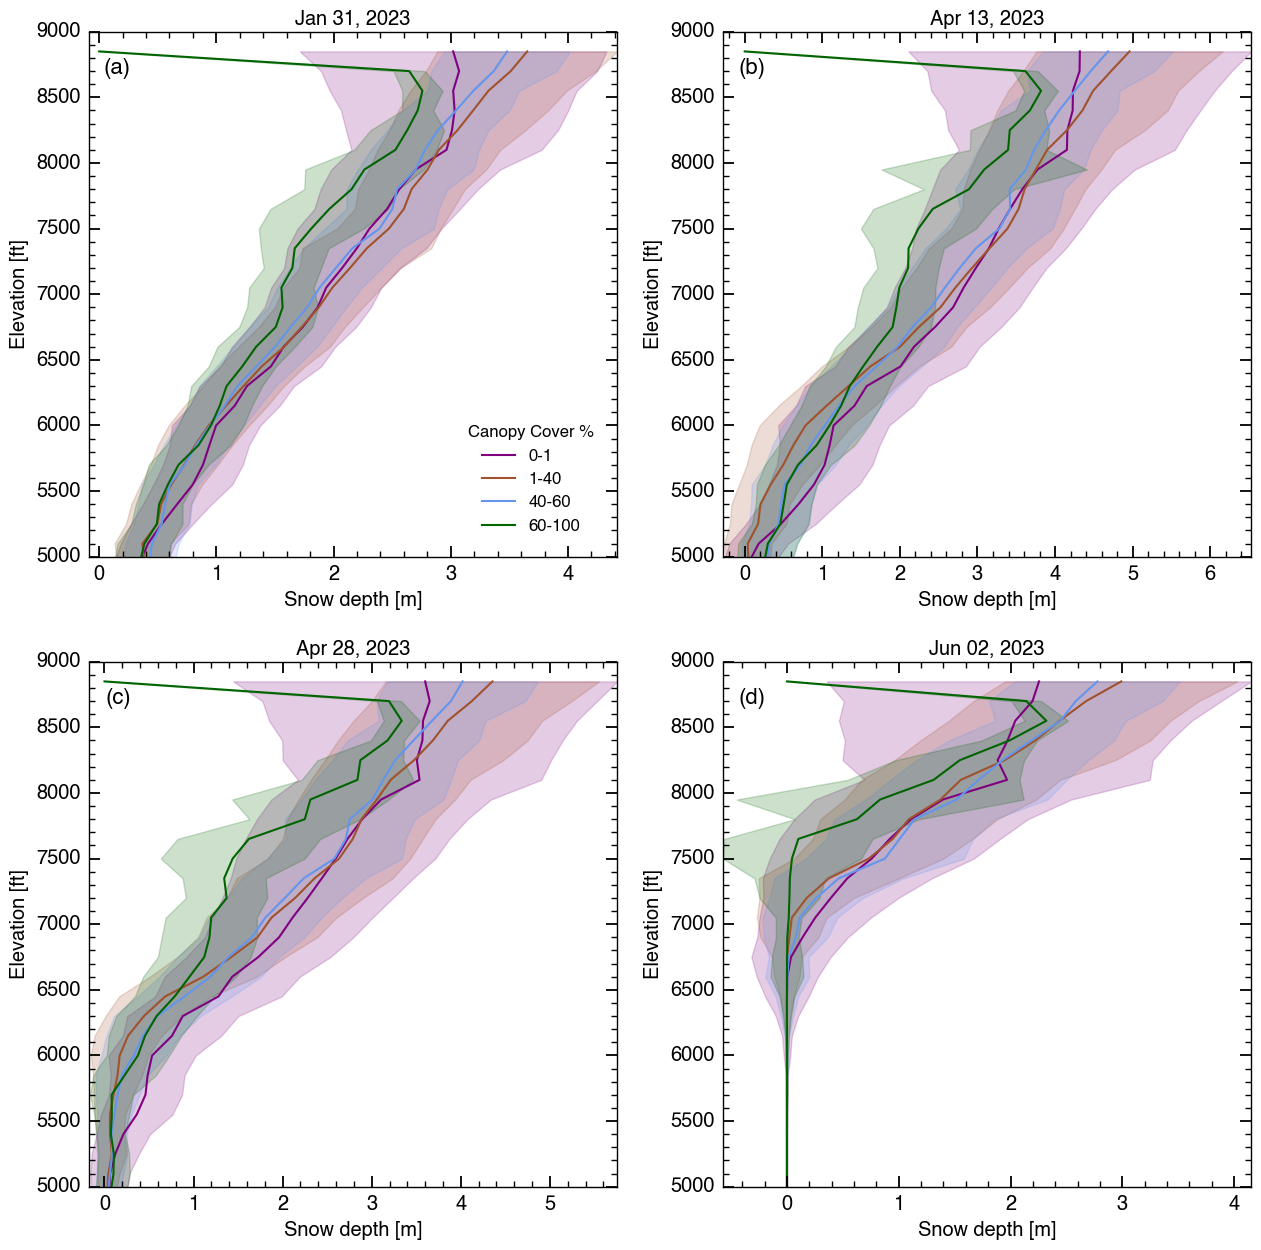

In [21]:
colors = ['purple',
          'sienna',
          'cornflowerblue',
          'darkgreen']
fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates23):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    sd = xr.open_rasterio(fn)
    sd = sd.rio.reproject('epsg:4326')
    sd = sd.rio.reproject_match(ds_50m)
    sd = sd.where(sd >= 0)
    inside = sd# .rio.clip(caldor.geometry, invert=False)
    outside = sd.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(covercat):
        cover_mask = covermasks[category]# .rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(cover_mask)
        srtm_50_in = srtm_50.where(cover_mask)# .rio.clip(caldor.geometry, invert=False).where(cover_mask)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands, mainline  - np.array(stds), 
                        mainline +np.array(stds), elevation_bands, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')
    ax.set_xlabel('Snow depth [m]')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


axs[0].legend(frameon = False, title = 'Canopy Cover %', loc = 'lower right')

plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_14012/2241982474.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 546 but corresponding boolean dimension is 1414

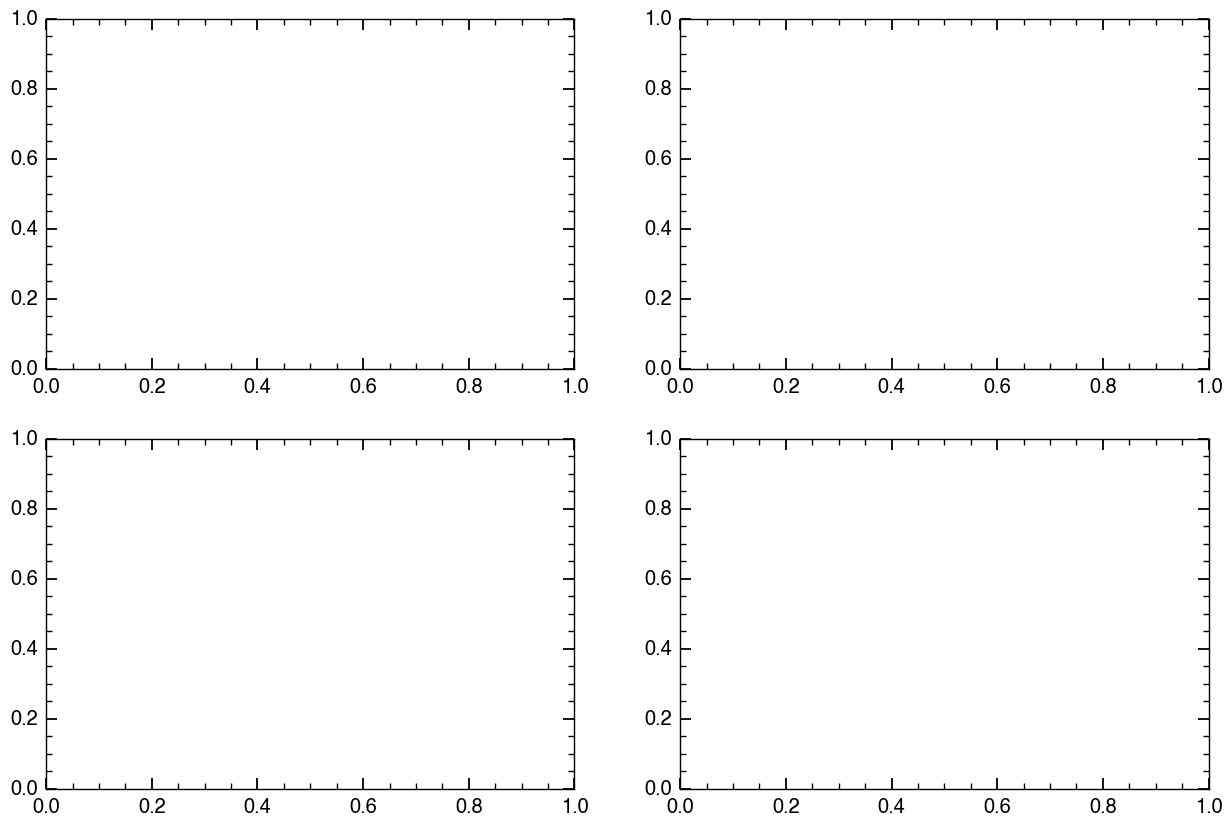

In [23]:
colors = ['purple',
          'sienna',
          'cornflowerblue',
          'darkgreen']
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs = axs.flatten()
for i,date in enumerate(dates23):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    swe = swe.rio.reproject_match(ds_50m)

    inside = swe.rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    category = covercat[0]
    category_mask = covermasks[category].rio.clip(caldor.geometry, invert=False)
    inside_category = inside.where(category_mask)
    elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
    baseline = np.array(band_means)
    for j, category in enumerate(covercat[0:]):
        category_mask = covermasks[category].rio.clip(caldor.geometry, invert=False)
        inside_category = inside.where(category_mask)
        srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert=False).where(category_mask)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means) #  - baseline
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        # ax.fill_betweenx(elevation_bands, mainline  - np.array(stds), 
        #                 mainline +np.array(stds), elevation_bands, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')
    ax.set_xlabel('SWE')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    ax.text(0, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    

axs[0].legend(frameon = False, title = 'Canopy Cover %', loc = 'lower right')


plt.show()

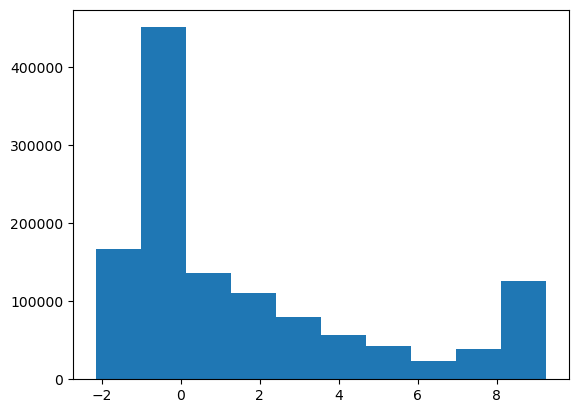

In [ ]:
fig, ax = plt.subplots()
ax.hist(log_area_rp.values.flatten())
plt.show()

In [10]:
## new raster: patch size! ## 

areacat = ["-2- -1", "-1-0","0-1", "1-2" , "2-6", "6-10"] #40-60","60-100"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red", "purple", "black", "gray"]
# Define the area size categories and their cutoff values
bounds = [-2,-1,0,1,2,6,10]

areacat = ["-2-0", "0-2","1-8", "8+"] #  , "2-6", "6-10"] #40-60","60-100"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red", "purple", "black", "gray"]
# Define the area size categories and their cutoff values
bounds = [-2,-1,0,4,6,10]
areacat = [f'{bounds[i]}-{bounds[i+1]}' for i in range(len(bounds)-1)]
# Create an empty dictionary to store masks for each category
lowcoverpatmasks = {}

# Create masks for each category
for i in range(len(bounds) - 1):
    lower_bound = bounds[i]
    upper_bound = bounds[i + 1]
    category_label = areacat[i]

    # Create a mask for the current category
    mask = (log_area_rp >= lower_bound) & (log_area_rp < upper_bound) & (band_data_rp < 10)

    # Add the mask to the dictionary with the category label as the key
    lowcoverpatmasks[category_label] = mask


In [11]:
## new raster: patch size! ## 

areacat = ["-2-0", "0-2","1-8", "8+"] #  , "2-6", "6-10"] #40-60","60-100"]
colors = ["lightgreen", "darkgreen", "yellow", "orange", "red", "purple", "black", "gray"]
# Define the area size categories and their cutoff values
bounds = [-2,0,2,8,20]
areacat = [f'{bounds[i]}-{bounds[i+1]}' for i in range(len(bounds)-1)]

# Create an empty dictionary to store masks for each category
medcoverpatmasks = {}

# Create masks for each category
for i in range(len(bounds) - 1):
    lower_bound = bounds[i]
    upper_bound = bounds[i + 1]
    category_label = areacat[i]

    # Create a mask for the current category
    mask = (log_area_rp >= lower_bound) & (log_area_rp < upper_bound) & (band_data_rp > 30) & (band_data_rp < 80)

    # Add the mask to the dictionary with the category label as the key
    medcoverpatmasks[category_label] = mask


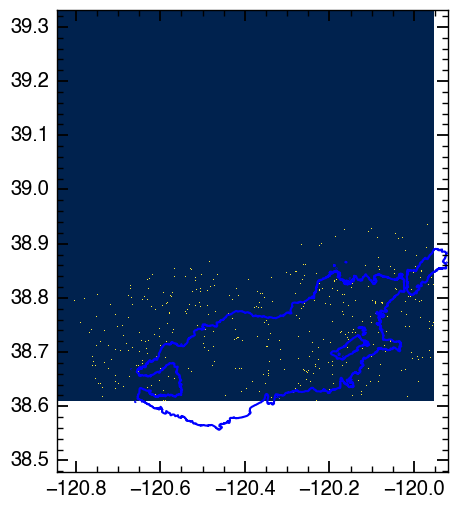

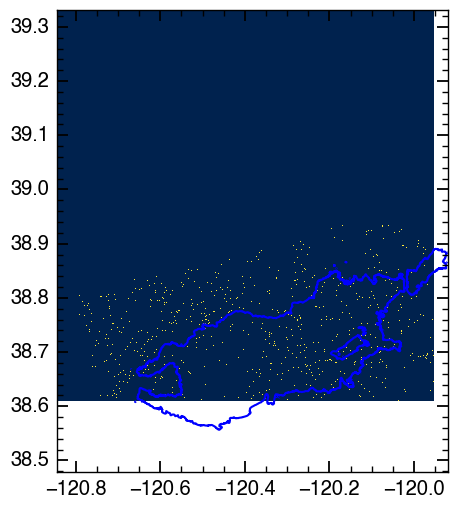

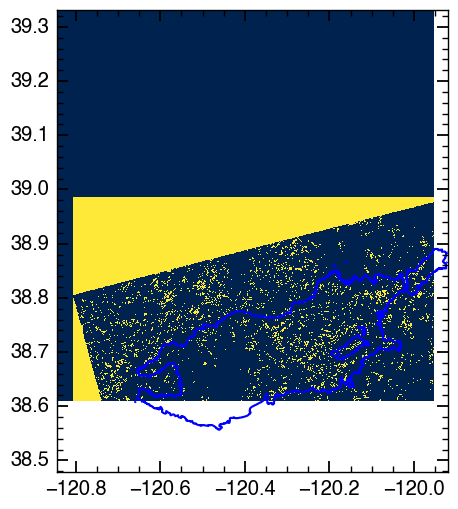

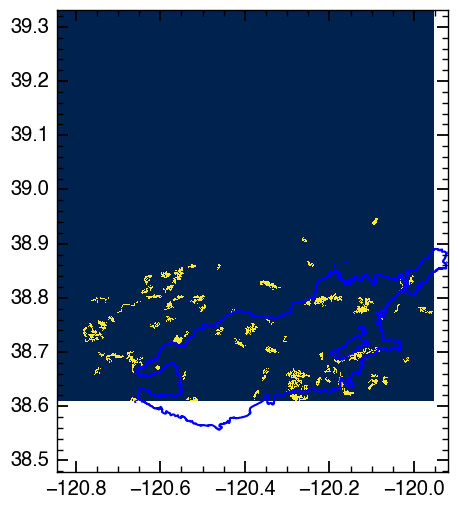

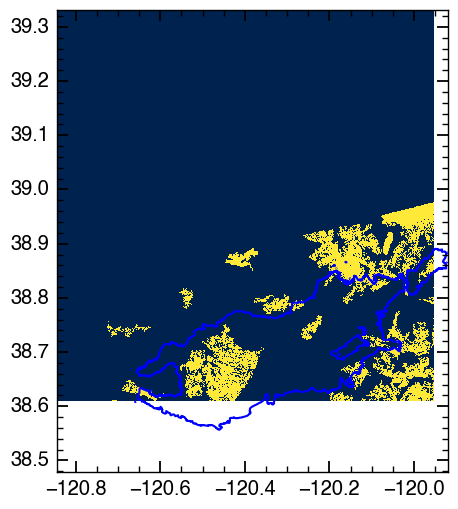

In [12]:
for key in lowcoverpatmasks.keys():
    fig, ax = plt.subplots()
    data = lowcoverpatmasks[key]
    ax.pcolormesh(data.x, data.y, data)
    caldor.boundary.plot(ax=ax)
    plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_14012/3081549937.py:18: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_14012/3081549937.py:18: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_14012/3081549937.py:18: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_14012/3081549937.py:18: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


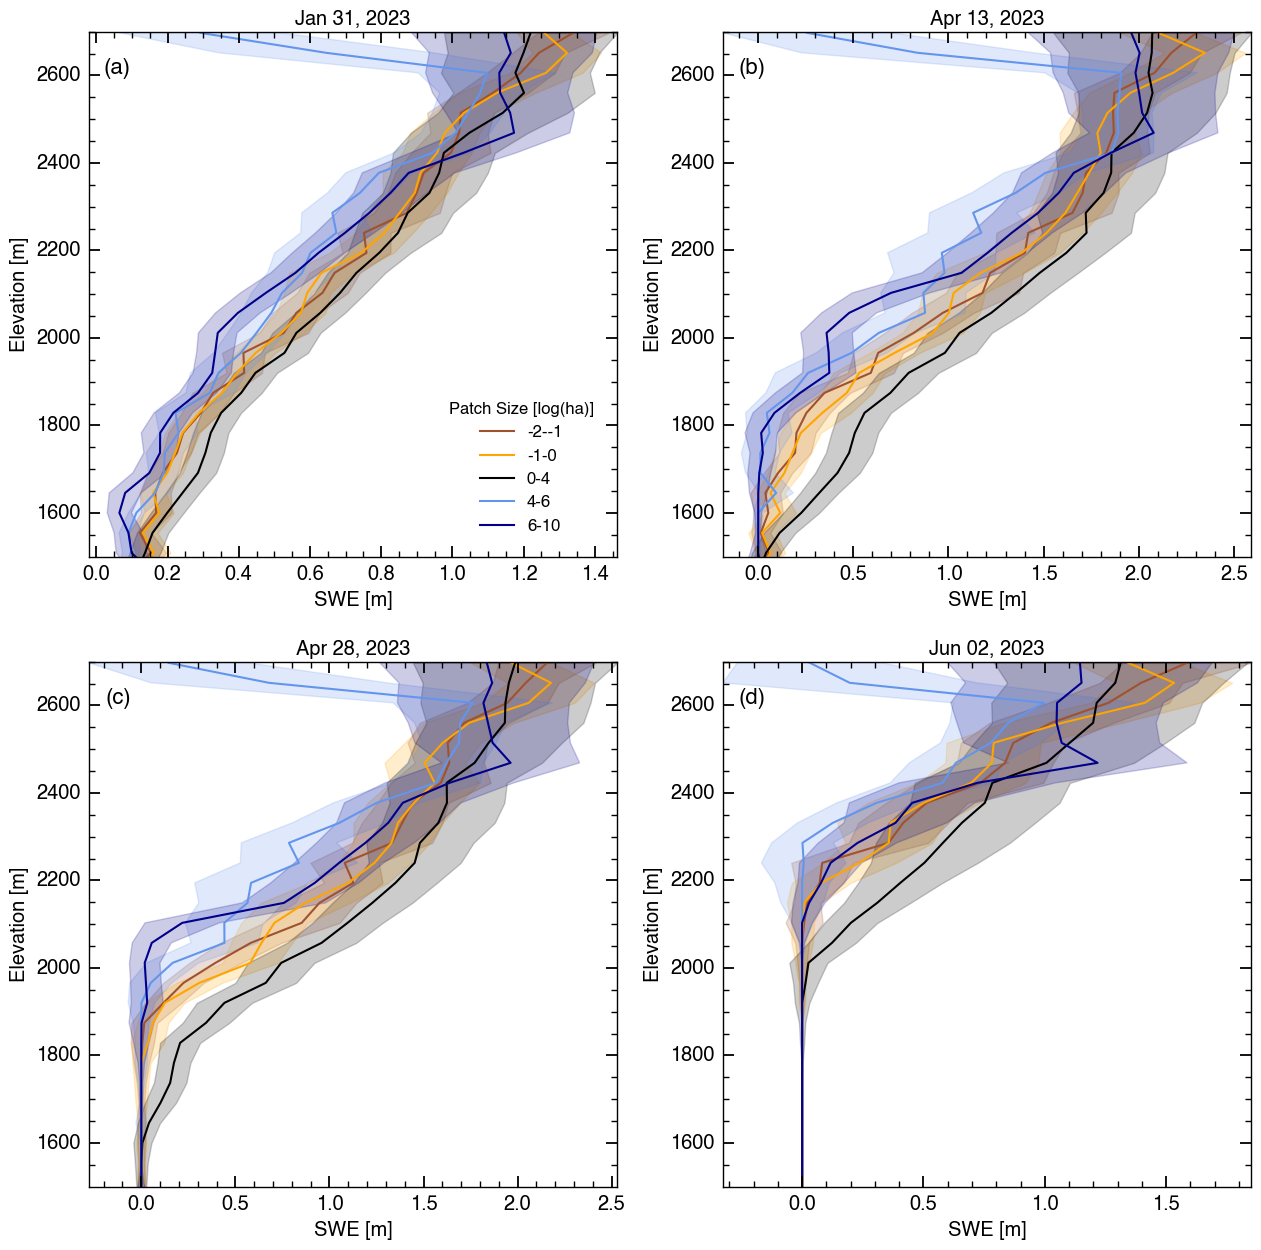

In [31]:

## given 0-10 % canopy cover, delineate by patch size
colors = [
          'sienna',
          'orange',
          'black',
          'cornflowerblue',
          'darkblue',
          'pink']

bounds = [-2,-1,0,4,6,10]
areacat = [f'{bounds[i]}-{bounds[i+1]}' for i in range(len(bounds)-1)]

fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates23):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    inside = swe # .rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(lowcoverpatmasks.keys()):
        print(category)
        category_mask = lowcoverpatmasks[category]# .rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = inside.where(mask2)
        srtm_50_in = srtm_50.where(mask2) # # .rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        elevation_bands_m = elevation_bands / 3.28084
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands_m, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands_m, mainline  - np.array(stds)/2, 
                        mainline +np.array(stds)/2, elevation_bands_m, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')

    ax.set_xlabel('SWE [m]')
    ax.set_ylabel('Elevation [m]')
    ax.set_ylim((1500,2700))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

axs[0].legend(frameon = False, title = 'Patch Size [log(ha)]', loc = 'lower right')

plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_75283/1899918309.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2-0


KeyError: '-2-0'

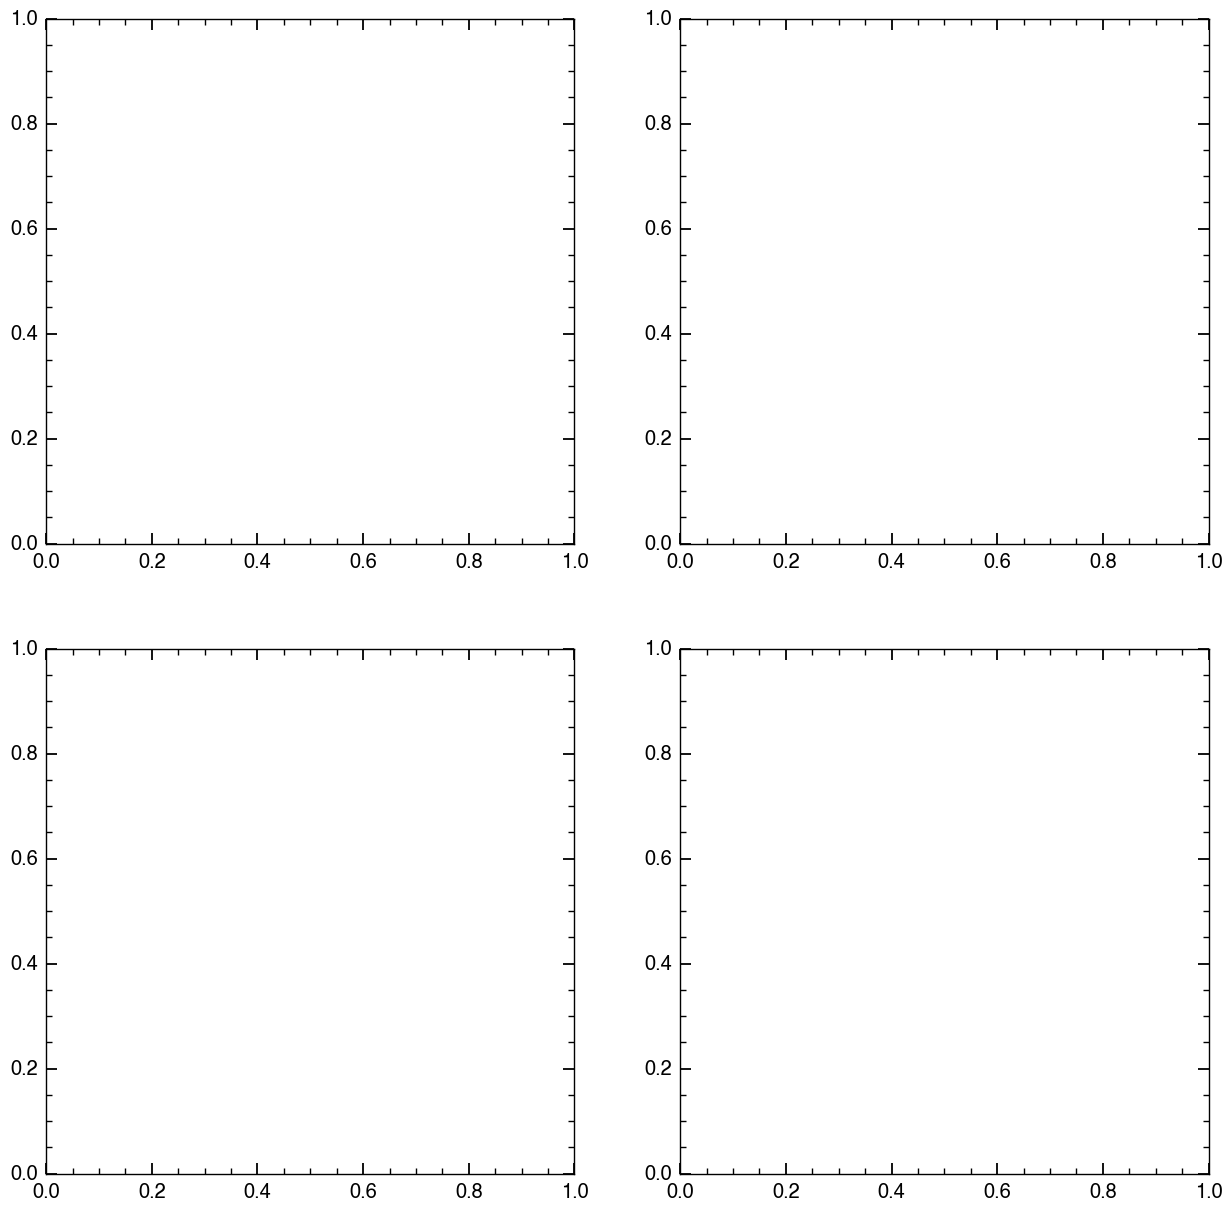

In [13]:

## given 0-10 % canopy cover, delineate by patch size
colors = [
          'sienna',
          'orange',
          'black',
          'cornflowerblue',
          'darkblue',
          'pink']

fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    swe = swe.where(swe>=0)
    inside = swe # .rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(areacat):
        print(category)
        category_mask = lowcoverpatmasks[category]# .rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = inside.where(mask2)
        srtm_50_in = srtm_50.where(mask2) # # .rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        elevation_bands_m = elevation_bands / 3.28084
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands_m, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands_m, mainline  - np.array(stds)/2, 
                        mainline +np.array(stds)/2, elevation_bands_m, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')

    ax.set_xlabel('Snow Depth [m]')
    ax.set_ylabel('Elevation [m]')
    ax.set_ylim((1500,2700))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

axs[0].legend(frameon = False, title = 'Patch Size [log(ha)]', loc = 'lower right')

plt.show()

{'-2--1': <xarray.DataArray (y: 1414, x: 1741)>
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])
 Coordinates:
   * x            (x) float64 -120.8 -120.8 -120.8 ... -120.0 -120.0 -120.0
   * y            (y) float64 39.33 39.33 39.33 39.33 ... 38.61 38.61 38.61 38.61
     spatial_ref  int64 0,
 '-1-0': <xarray.DataArray (y: 1414, x: 1741)>
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, Fal

In [30]:
lowcoverpatmasks.keys()

dict_keys(['-2--1', '-1-0', '0-4', '4-6', '6-10'])

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/1899918309.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/1899918309.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/1899918309.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/1899918309.py:15: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


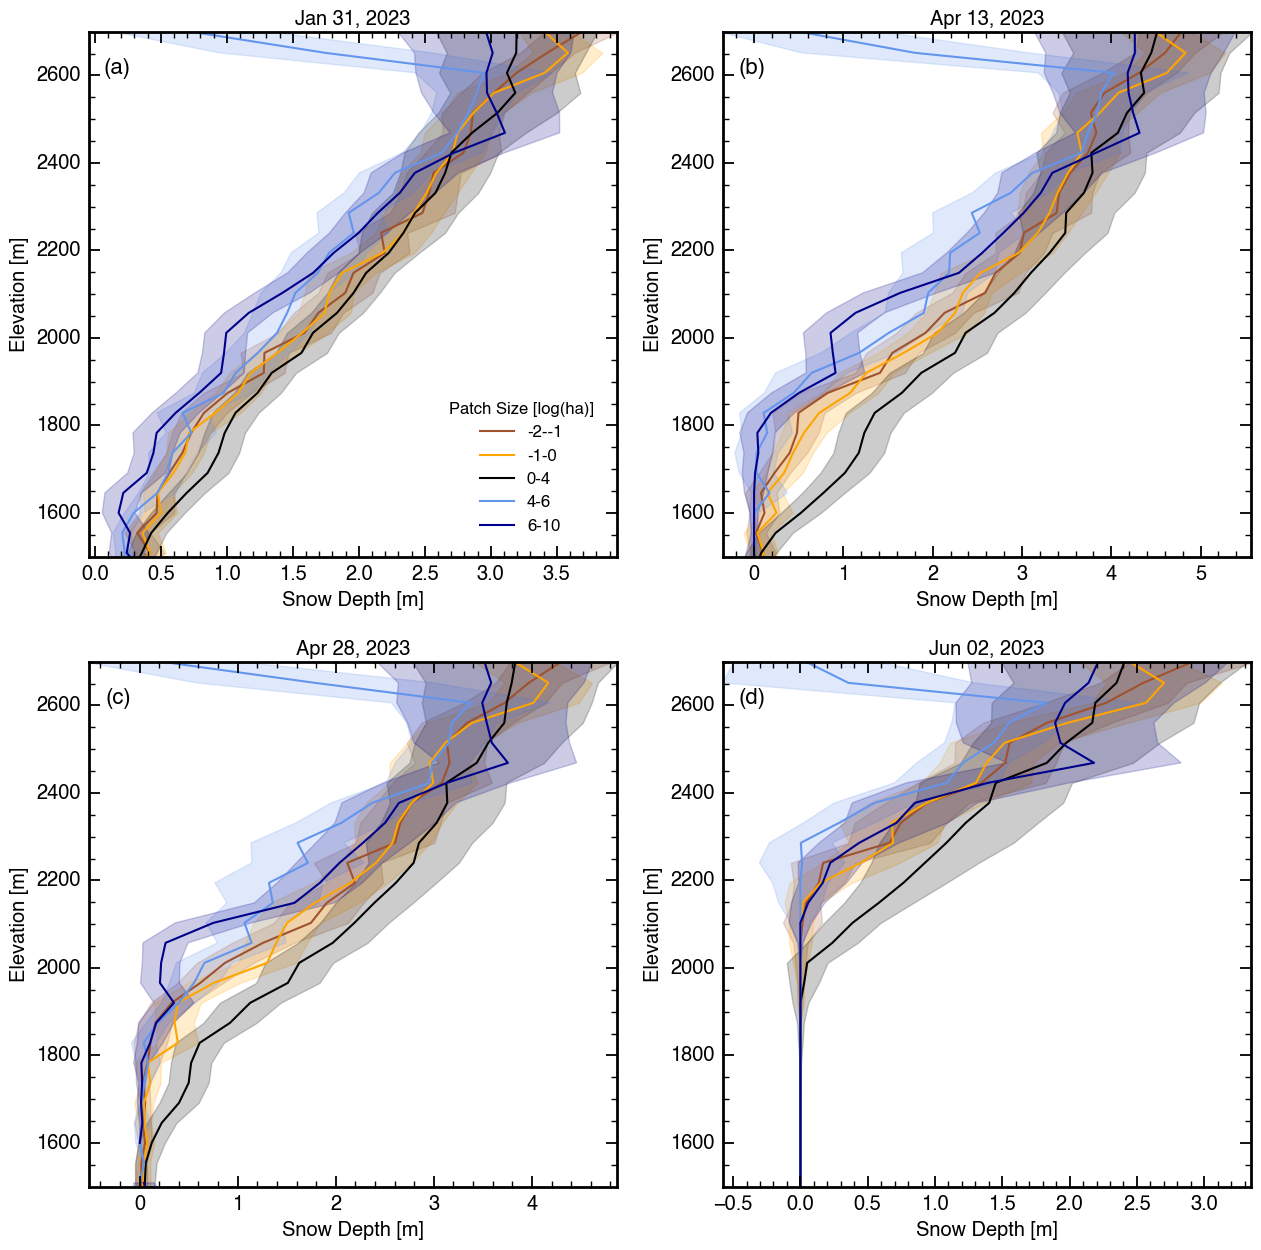

In [46]:

## given 0-10 % canopy cover, delineate by patch size
colors = [
          'sienna',
          'orange',
          'black',
          'cornflowerblue',
          'darkblue',
          'pink']

fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    swe = swe.where(swe>=0)
    inside = swe # .rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(areacat):
        print(category)
        category_mask = lowcoverpatmasks[category]# .rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = inside.where(mask2)
        srtm_50_in = srtm_50.where(mask2) # # .rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        elevation_bands_m = elevation_bands / 3.28084
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands_m, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands_m, mainline  - np.array(stds)/2, 
                        mainline +np.array(stds)/2, elevation_bands_m, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')

    ax.set_xlabel('Snow Depth [m]')
    ax.set_ylabel('Elevation [m]')
    ax.set_ylim((1500,2700))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

axs[0].legend(frameon = False, title = 'Patch Size [log(ha)]', loc = 'lower right')

plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/675205778.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/675205778.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/675205778.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/675205778.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2--1


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-1-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-4
4-6


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


6-10


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


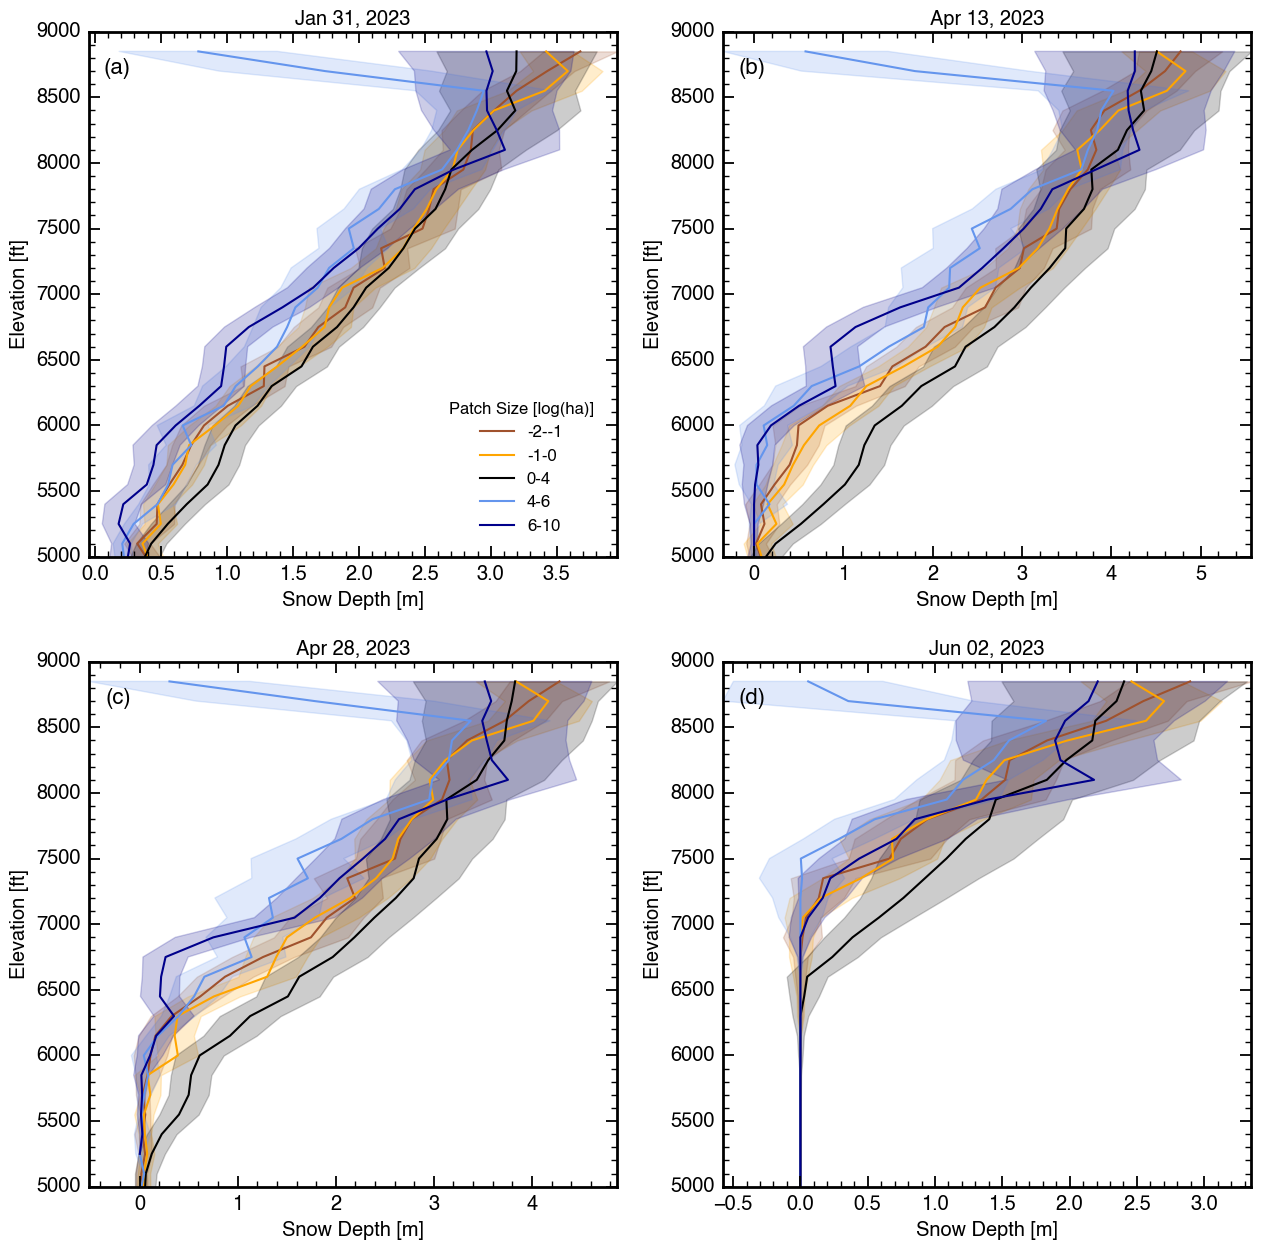

In [32]:

## given 0-10 % canopy cover, delineate by patch size
colors = [
          'sienna',
          'orange',
          'black',
          'cornflowerblue',
          'darkblue',
          'pink']
fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    swe = swe.where(swe >= 0)
    inside = swe # .rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(areacat):
        print(category)
        category_mask = lowcoverpatmasks[category]# .rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = inside.where(mask2)
        srtm_50_in = srtm_50.where(mask2) # # .rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands, mainline  - np.array(stds)/2, 
                        mainline +np.array(stds)/2, elevation_bands, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')

    ax.set_xlabel('Snow Depth [m]')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

axs[0].legend(frameon = False, title = 'Patch Size [log(ha)]', loc = 'lower right')

print('patch size, snow depth, all ASO coverage area')
plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_67187/3933870085.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = 

patch size, snow depth, inside caldor fire


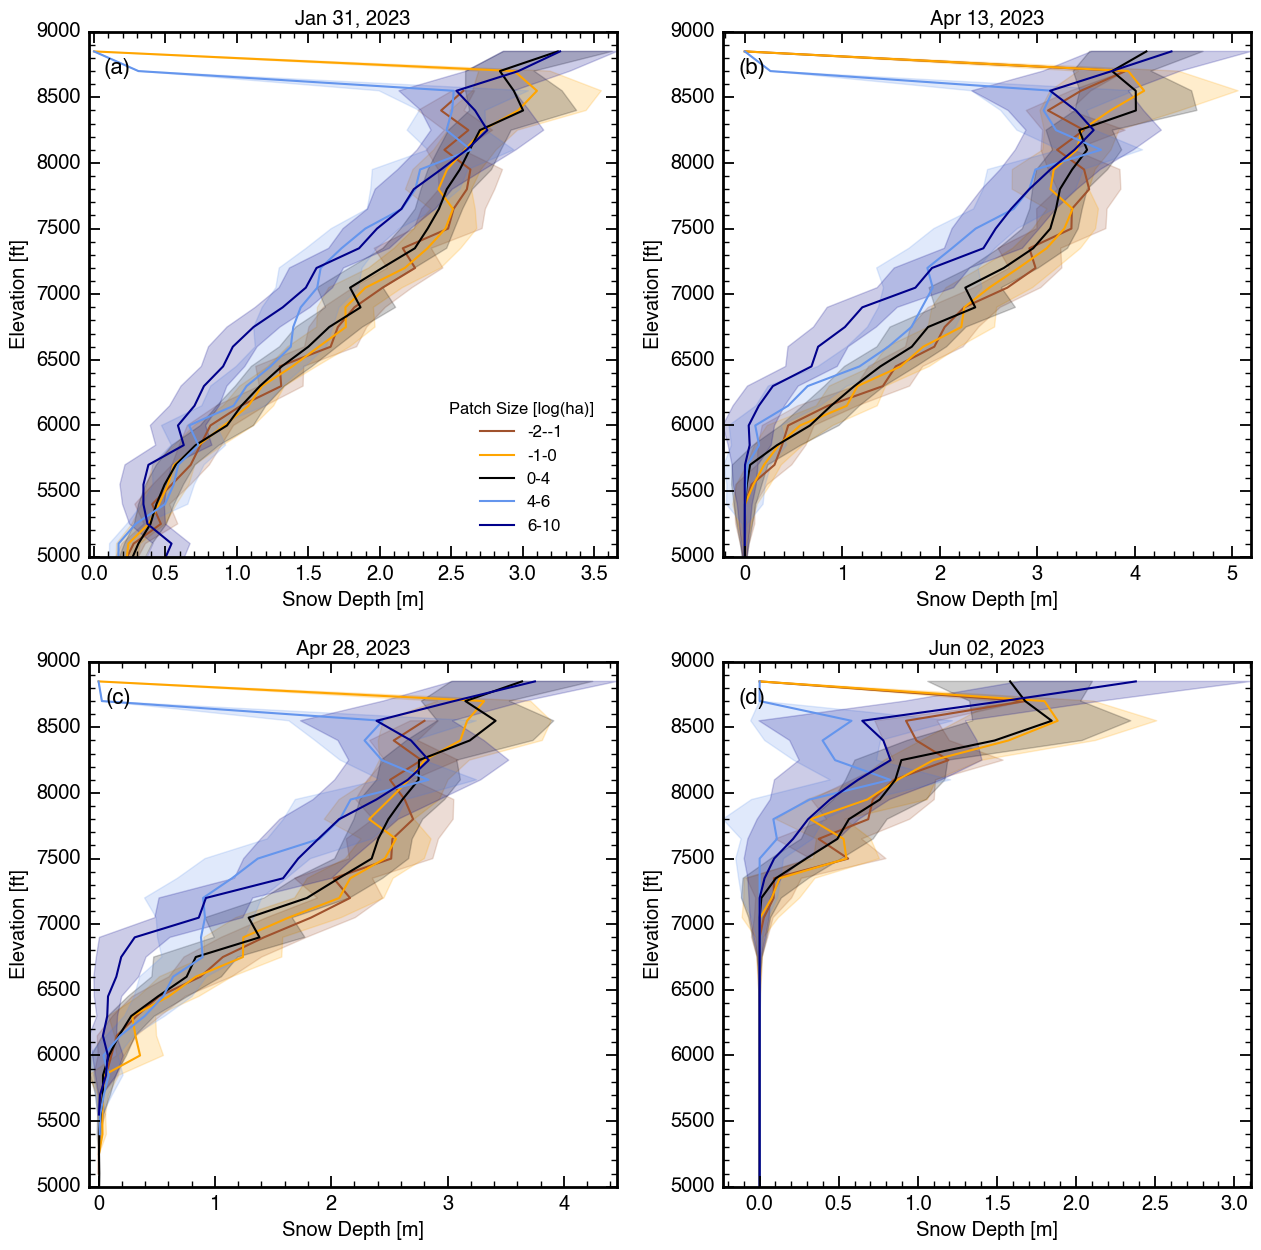

In [36]:

## given 0-10 % canopy cover, delineate by patch size
colors = [
          'sienna',
          'orange',
          'black',
          'cornflowerblue',
          'darkblue',
          'pink']
fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs = axs.flatten()
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*snowdepth_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    # swe = swe.where(swe >= 0)
    # inside = swe# .rio.clip(caldor.geometry, invert=False)
    #outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(areacat):
        # print(category)
        category_mask = lowcoverpatmasks[category]# .rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = swe.where(mask2).rio.clip(caldor.geometry).where(swe>=0)
        srtm_50_in = srtm_50.where(mask2).rio.clip(caldor.geometry) # # .rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands, mainline  - np.array(stds)/2, 
                        mainline +np.array(stds)/2, elevation_bands, color=colors[j], alpha = 0.2)

    ax.set_title(f'{date[4:7]} {date[7:]}, {date[0:4]}')

    ax.set_xlabel('Snow Depth [m]')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    
    ax.text(0.08, 0.95,f'({chr(97+i)})', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

axs[0].legend(frameon = False, title = 'Patch Size [log(ha)]', loc = 'lower right')

print('patch size, snow depth, inside caldor fire')
plt.show()

In [26]:
sd

<xarray.DataArray (band: 1, y: 1414, x: 1741)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -120.8 -120.8 -120.8 ... -120.0 -120.0 -120.0
  * y            (y) float64 39.33 39.33 39.33 39.33 ... 38.61 38.61 38.61 38.61
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('ASO SWE [m]',)
    AREA_OR_POINT:  Area
    Band_1:         ASO SWE [m]
    _FillValue:     nan

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/4175244006.py:19: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/4175244006.py:40: RuntimeWarning: invalid value encountered in divide
 

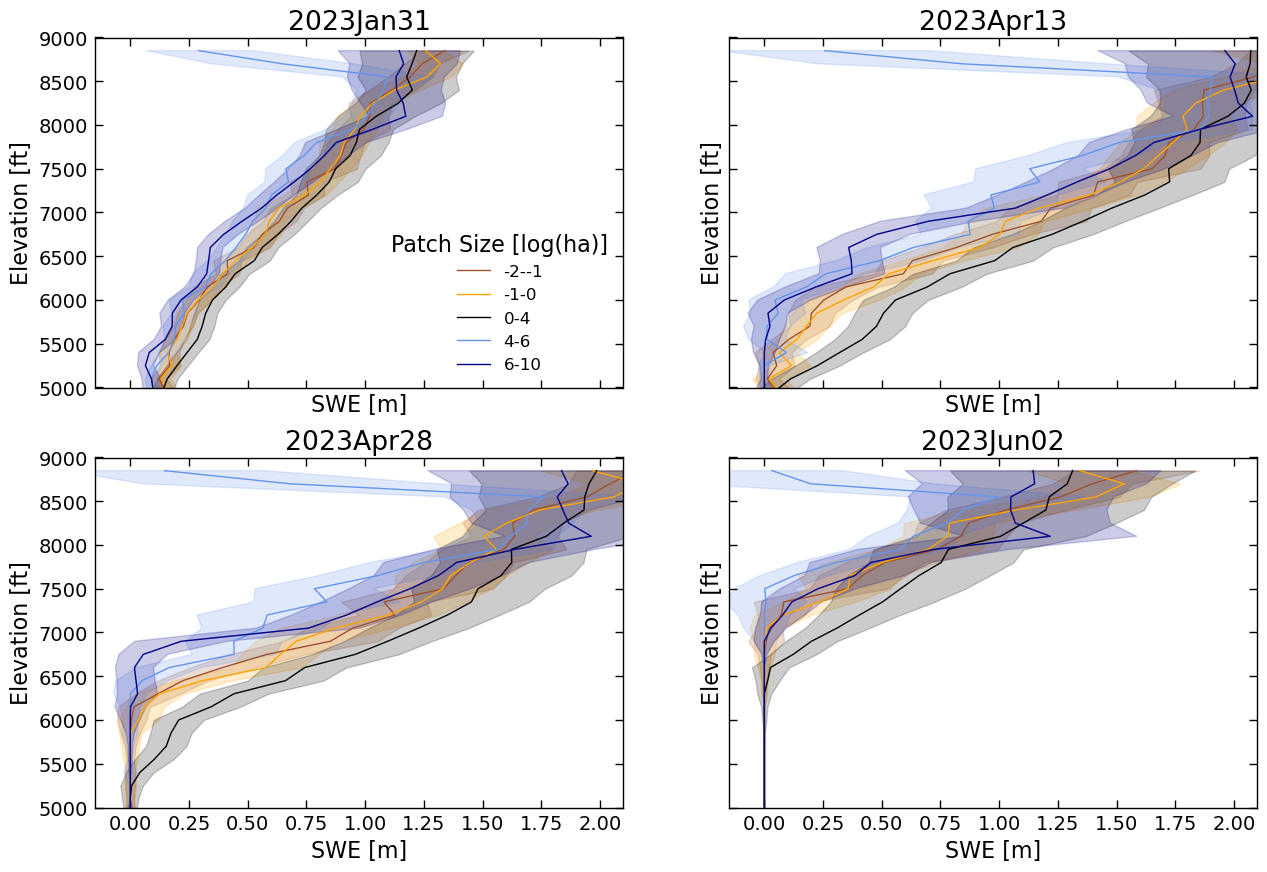

In [ ]:

## given 0-10 % canopy cover, delineate by patch size
colors = [
          'sienna',
          'orange',
          'black',
          'cornflowerblue',
          'darkblue',
          'pink']
fig, axs = plt.subplots(2,2,figsize=(15, 10), sharex = True, sharey = True)
axs = axs.flatten()
outs = {}
for cat in areacat:
    outs[cat] = []
    
baselines = []
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    inside = swe # .rio.clip(caldor.geometry, invert=False)
    
    category_mask = lowcoverpatmasks['0-4']# .rio.clip(caldor.geometry, invert=False)
    mask2 = (category_mask)
    inside_category = inside.where(mask2)
    srtm_50_in = srtm_50.where(mask2)
    elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside, srtm_50, STATIC=True)
    baseline = band_means
    baselines.append(baseline)
    for j, category in enumerate(areacat):
        category_mask = lowcoverpatmasks[category]# .rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = inside.where(mask2)
        srtm_50_in = srtm_50.where(mask2) # # .rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means) 
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands, mainline  - np.array(stds)/2, 
                        mainline +np.array(stds)/2, elevation_bands, color=colors[j], alpha = 0.2)
        outs[category].append(mainline/baseline)
       

    ax.set_title(date)
    ax.set_xlabel('SWE [m]')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    ax.set_xlim((-.15, 2.1))
    

axs[0].legend(frameon = False, title = 'Patch Size [log(ha)]', loc = 'lower right')

plt.show()

In [ ]:
cat

'6-10'

In [ ]:
np.array(baselines).shape 
# by 4 dates by 50 elevations
# np.array(baselines).mean(axis = 1).shape # mean by elevation



(4, 50)

In [ ]:
len(outs) ## 20 dates by 5 categories

20

In [ ]:
areacat

['-2--1', '-1-0', '0-4', '4-6', '6-10']

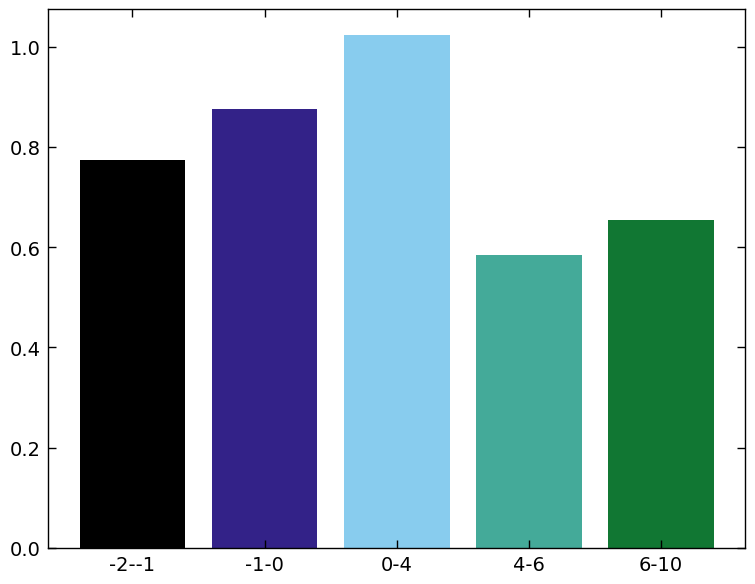

In [ ]:
fig, ax = plt.subplots()
x = areacat
for i,cat in enumerate(areacat):
    alldates = np.nanmean(np.array(outs[cat]))
    ax.bar(i, alldates)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(areacat)
plt.show()

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/1575740371.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/1575740371.py:3: DeprecationWarning: open_rasterio is Deprecated in favo

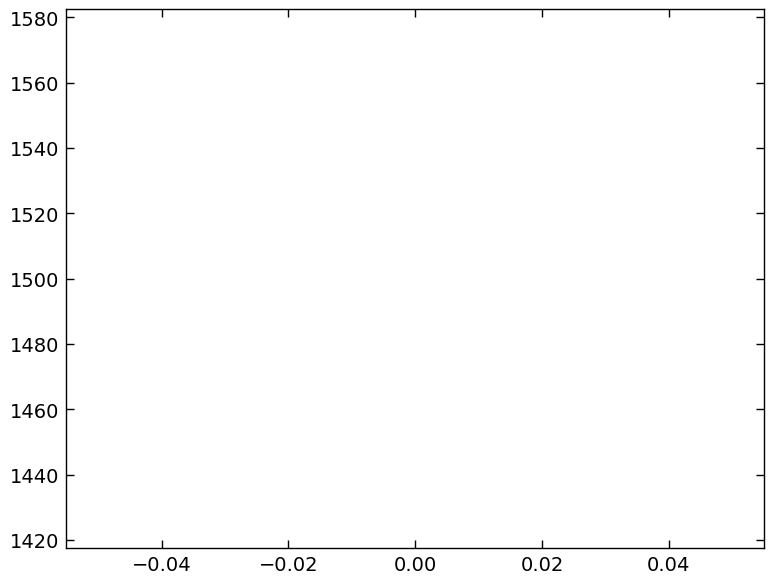

In [ ]:
for date in dates:
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    inside = swe # .rio.clip(caldor.geometry, invert=False)
    
    category_mask = lowcoverpatmasks['-2--1']# .rio.clip(caldor.geometry, invert=False)
    mask2 = (category_mask)
    inside_category = inside.where(mask2)
    elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
    baseline = band_means
    plt.plot(baseline, elevation_bands)

In [ ]:
lowcoverpatmasks.keys()

dict_keys(['-2--1', '-1-0', '0-4', '4-6', '6-10'])

In [ ]:
baseline

[0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
baseline

[0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/3799482157.py:13: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-2


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1-8


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/3799482157.py:13: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-2


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1-8


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/3799482157.py:13: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-2


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1-8


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_48399/3799482157.py:13: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  swe = xr.open_rasterio(fn)


-2-0


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0-2


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


1-8


/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/opt/anaconda3/envs/snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


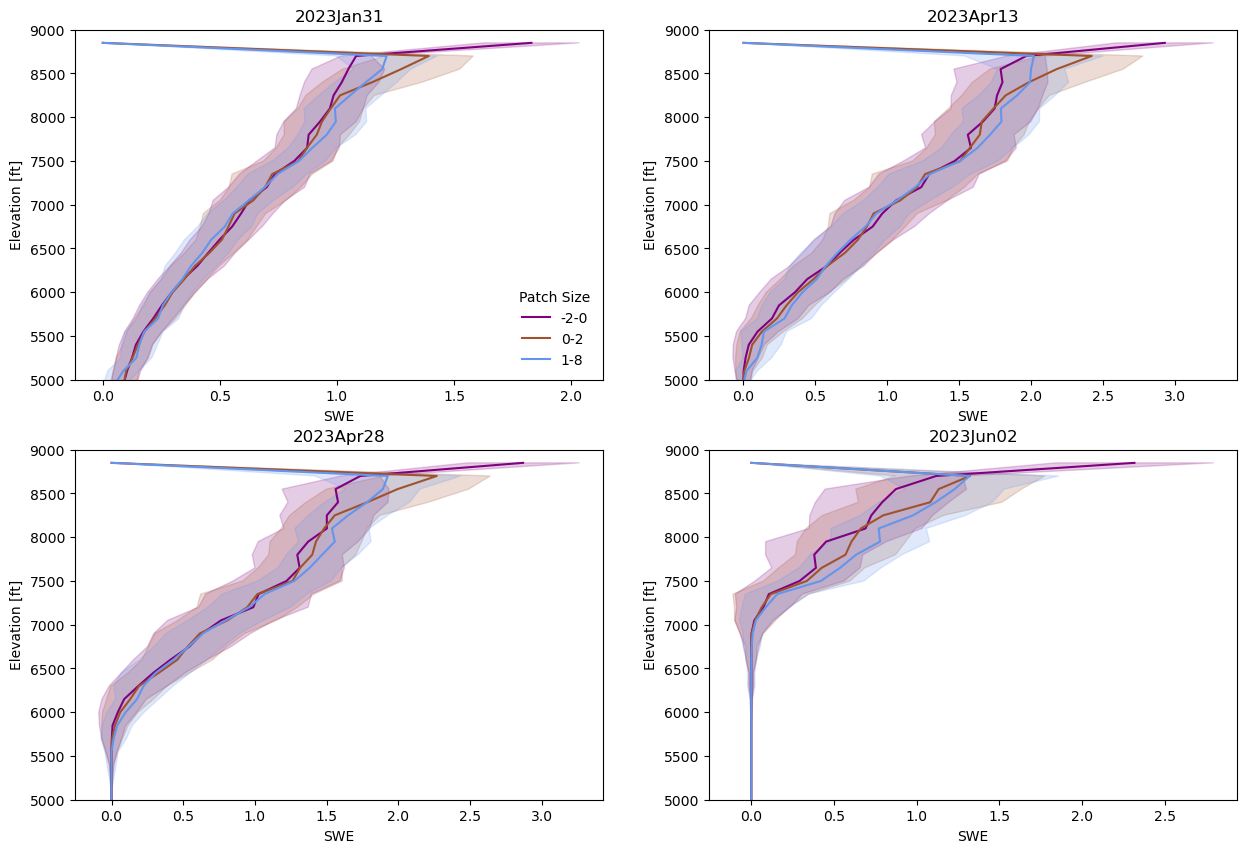

In [ ]:

## given 0-10 % canopy cover, delineate by patch size
colors = ['purple',
          'sienna',
          'cornflowerblue',
          'darkgreen',
          'orange',
          'black']
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs = axs.flatten()
for i,date in enumerate(dates[0:4]):
    ax = axs[i]
    fn = glob.glob(f'{datadir}*American*/*{date}*swe_50m.tif')[0]
    swe = xr.open_rasterio(fn)
    swe = swe.rio.reproject('epsg:4326')
    inside = swe.rio.clip(caldor.geometry, invert=False)
    outside = swe.rio.clip(caldor.geometry, invert=True)
    for j, category in enumerate(areacat[:-1]):
        print(category)
        category_mask = medcoverpatmasks[category].rio.clip(caldor.geometry, invert=False)
        mask2 = (category_mask)
        inside_category = inside.where(mask2)
        srtm_50_in = srtm_50.rio.clip(caldor.geometry, invert=False).where(mask2)
        elevation_bands, band_means, percentiles_25, percentiles_75, stds = get_elev(inside_category, srtm_50_in, STATIC=True)
        mainline = np.array(band_means)
        ax.plot(mainline, elevation_bands, label=category, linestyle='-', color=colors[j])
        ax.fill_betweenx(elevation_bands, mainline  - np.array(stds), 
                        mainline +np.array(stds), elevation_bands, color=colors[j], alpha = 0.2)

    ax.set_title(date)
    ax.set_xlabel('SWE')
    ax.set_ylabel('Elevation [ft]')
    ax.set_ylim((5000,9000))
    #ax.set_xlim((-1.15, 1.1))
    #ax.plot([0,0], [5000,9000], color='black', linestyle='--')
    

axs[0].legend(frameon = False, title = 'Patch Size', loc = 'lower right')

plt.show()

In [ ]:
inside_category

<xarray.Dataset>
Dimensions:      (y: 0, x: 0)
Coordinates:
  * y            (y) float64 
  * x            (x) float64 
    spatial_ref  int64 0
Data variables:
    band_data    (y, x) float32 
    log_area     (y, x) float32

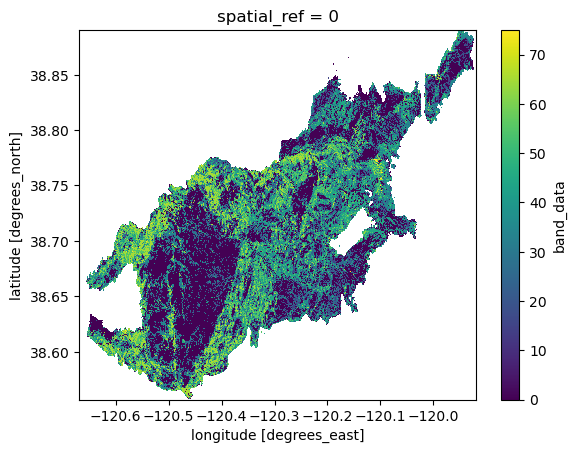

In [ ]:
inside.band_data.plot()

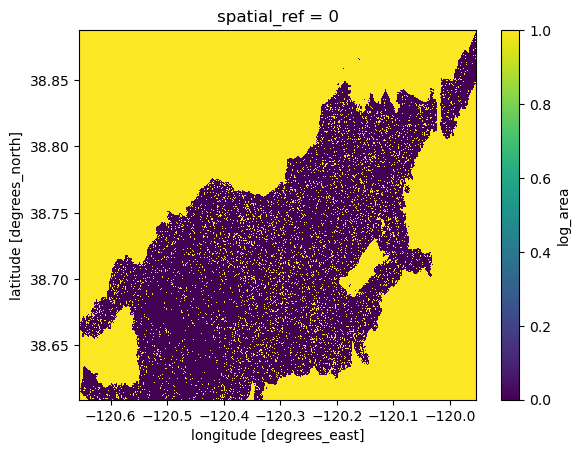

In [ ]:
mask2.plot()

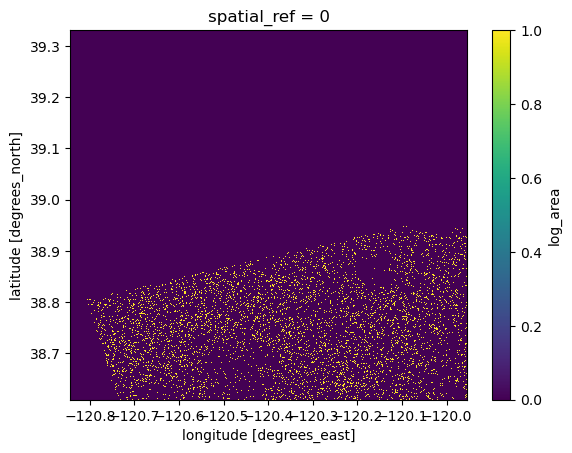

In [ ]:
lowcoverpatmasks['-2- -1'].plot()

In [ ]:
inside_category

<xarray.Dataset>
Dimensions:      (y: 0, x: 0)
Coordinates:
  * y            (y) float64 
  * x            (x) float64 
    spatial_ref  int64 0
Data variables:
    band_data    (y, x) float32 
    log_area     (y, x) float32